## Let's look at boundary and label monotonicity in Hierarchical labels: SALAMI.


In [2]:
%load_ext autoreload
%autoreload 2

In [62]:
# Let's get the directory of jams files:
import os, jams, mir_eval, bnl, json, tqdm
import numpy as np
import xarray as xr
from tqdm import tqdm


In [40]:
# DATA_DIR = '/Users/xi/data/salami-jams'
DATA_DIR = '/Users/tomxi/data/salami-jams'

def load_jams(tid, salami_jams_dir=DATA_DIR):
    jams_path = os.path.join(salami_jams_dir, tid + '.jams')
    return jams.load(jams_path)

def get_salami_tids(salami_jams_dir=DATA_DIR):
    found_jams_files = os.listdir(salami_jams_dir)
    tids = sorted([os.path.splitext(f)[0] for f in found_jams_files])
    return tids

In [41]:
def get_ref_hiers(tid):
    jam = load_jams(str(tid))
    duration = jam.file_metadata.duration
    upper = jam.search(namespace='segment_salami_upper')
    lower = jam.search(namespace='segment_salami_lower')
    anno_h_list = []
    for anno_id in range(len(upper)):
        upper[anno_id].duration = duration
        lower[anno_id].duration = duration
        anno_h = bnl.multi2H(bnl.fmt.openseg2multi([upper[anno_id], lower[anno_id]]))
        anno_h_list.append(anno_h)
    return anno_h_list

def get_adobe_hiers(tid, result_dir='/Users/tomxi/data/ISMIR21-Segmentations/SALAMI/def_mu_0.1_gamma_0.1/') -> jams.Annotation:
    filename = f'{tid}.mp3.msdclasscsnmagic.json'

    with open(os.path.join(result_dir, filename), 'rb') as f:
        adobe_hier = json.load(f)

    anno = bnl.fmt.hier2multi(adobe_hier)
    anno.sandbox.update(mu=0.1, gamma=0.1)
    return bnl.multi2H(anno)

In [42]:
adobe_hier = get_adobe_hiers(10)

False


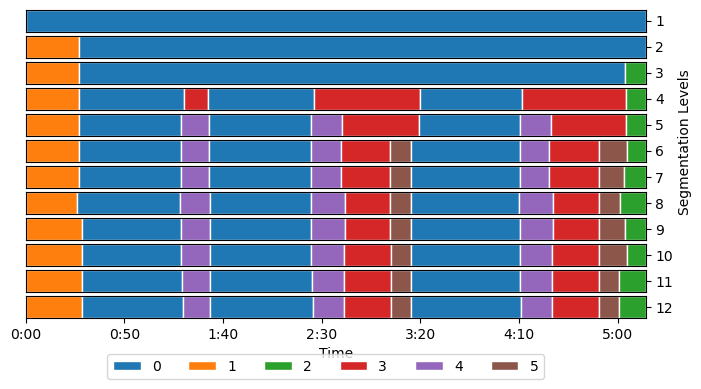

In [29]:
adobe_hier.plot()
print(adobe_hier.has_mono_B())

(<Figure size 800x400 with 12 Axes>,
 array([<Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
        <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
        <Axes: xlabel='Time'>], dtype=object))

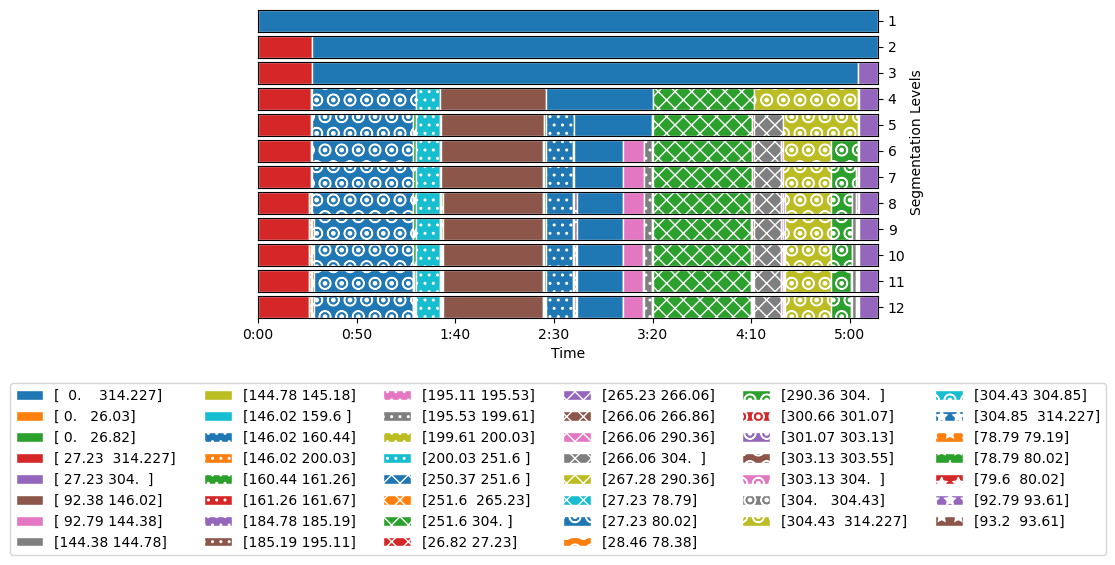

In [35]:
out = bnl.H(adobe_hier.force_mono_B(min_seg_dur=0).itvls)
out.plot(legend_offset=-0.5)

(<Figure size 800x400 with 12 Axes>,
 array([<Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
        <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
        <Axes: xlabel='Time'>], dtype=object))

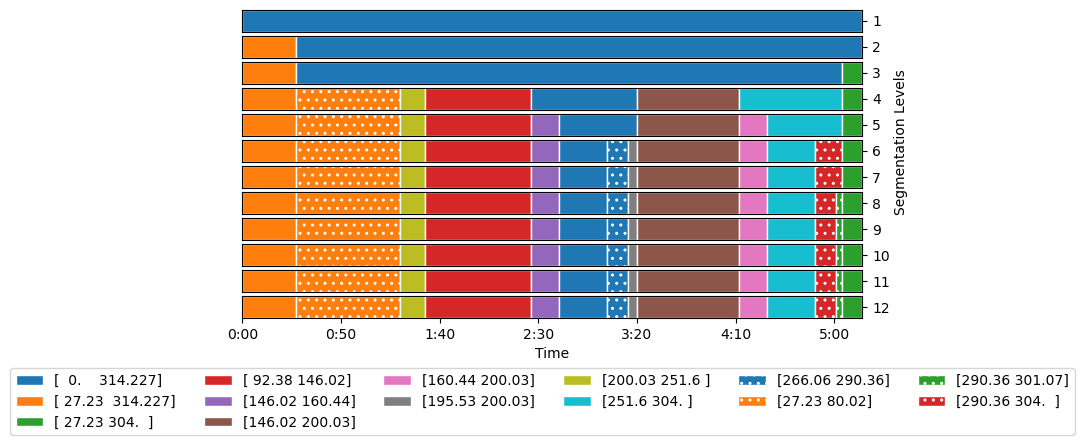

In [37]:
out = bnl.H(adobe_hier.force_mono_B(min_seg_dur=2).itvls)
out.plot(legend_offset=-0.2)

In [ ]:
# Now Let's look at T measures and L measures
tid = '10'
ref_hier = get_ref_hiers(tid)[0]
# adobe_hier = get_adobe_hiers(tid)
est_hier = get_adobe_hiers(tid)

eval_result = mir_eval.hierarchy.evaluate(ref_hier.itvls, ref_hier.labels, est_hier.itvls, est_hier.labels)
for k in eval_result:
    print(f'{k}: {eval_result[k]}')

/Users/tomxi/mir_eval/mir_eval/hierarchy.py:504: UserWarning: Segment hierarchy is inconsistent at level 3
  warnings.warn(
/Users/tomxi/mir_eval/mir_eval/hierarchy.py:504: UserWarning: Segment hierarchy is inconsistent at level 4
  warnings.warn(
/Users/tomxi/mir_eval/mir_eval/hierarchy.py:504: UserWarning: Segment hierarchy is inconsistent at level 5
  warnings.warn(
/Users/tomxi/mir_eval/mir_eval/hierarchy.py:504: UserWarning: Segment hierarchy is inconsistent at level 6
  warnings.warn(
/Users/tomxi/mir_eval/mir_eval/hierarchy.py:504: UserWarning: Segment hierarchy is inconsistent at level 7
  warnings.warn(
/Users/tomxi/mir_eval/mir_eval/hierarchy.py:504: UserWarning: Segment hierarchy is inconsistent at level 8
  warnings.warn(
/Users/tomxi/mir_eval/mir_eval/hierarchy.py:504: UserWarning: Segment hierarchy is inconsistent at level 9
  warnings.warn(
/Users/tomxi/mir_eval/mir_eval/hierarchy.py:504: UserWarning: Segment hierarchy is inconsistent at level 10
  warnings.warn(
/Users/

T-Precision reduced: 0.2585893354831497
T-Recall reduced: 0.39316533636992934
T-Measure reduced: 0.3119835344726996
T-Precision full: 0.5675121771365692
T-Recall full: 0.3734003277828668
T-Measure full: 0.45043345019993686
L-Precision: 0.4742267390974354
L-Recall: 0.5281539194517878
L-Measure: 0.49973971230780984


In [47]:
est_hier = get_adobe_hiers(tid).force_mono_B(min_seg_dur=2)
eval_result_mono_forcing = mir_eval.hierarchy.evaluate(ref_hier.itvls, ref_hier.labels, est_hier.itvls, est_hier.labels)
for k in eval_result_mono_forcing:
    print(f'{k}: {eval_result_mono_forcing[k]}')

T-Precision reduced: 0.23239343169639853
T-Recall reduced: 0.3878171265609426
T-Measure reduced: 0.290630824361872
T-Precision full: 0.5776865335462904
T-Recall full: 0.368631983264942
T-Measure full: 0.45006777059419534
L-Precision: 0.4723677139559227
L-Recall: 0.510492546767833
L-Measure: 0.4906907053718666


## Experiment: How monoboundary forcing change T measure on Adobe outputs against all annotations scatter plots

In [ ]:
# I want to iterate through all the tracks and compute T measure, before and after forcing mono B
full_results = {}
reduced_results = {}

bnl.utils.suppress_mir_eval_warnings()
for tid in tqdm(get_salami_tids()):
    for anno_id, ref_h in enumerate(get_ref_hiers(tid)):
        est_h = get_adobe_hiers(tid)
        est_h_mono0 = est_h.force_mono_B(min_seg_dur=0)
        est_h_mono1 = est_h.force_mono_B(min_seg_dur=0.5)
        t_measure_raw = mir_eval.hierarchy.tmeasure(*bnl.utils.pad_itvls(ref_h.itvls, est_h.itvls), transitive=True)
        t_measure_mono0 = mir_eval.hierarchy.tmeasure(*bnl.utils.pad_itvls(ref_h.itvls, est_h_mono0.itvls), transitive=True)
        t_measure_mono1 = mir_eval.hierarchy.tmeasure(*bnl.utils.pad_itvls(ref_h.itvls, est_h_mono1.itvls), transitive=True)
        full_results[f'{tid}_{anno_id}'] = (t_measure_raw, t_measure_mono0, t_measure_mono1)

        reduced_t_measure_raw = mir_eval.hierarchy.tmeasure(*bnl.utils.pad_itvls(ref_h.itvls, est_h.itvls), transitive=False)
        reduced_t_measure_mono0 = mir_eval.hierarchy.tmeasure(*bnl.utils.pad_itvls(ref_h.itvls, est_h_mono0.itvls), transitive=False)
        reduced_t_measure_mono1 = mir_eval.hierarchy.tmeasure(*bnl.utils.pad_itvls(ref_h.itvls, est_h_mono1.itvls), transitive=False)
        reduced_results[f'{tid}_{anno_id}'] = (reduced_t_measure_raw, reduced_t_measure_mono0, reduced_t_measure_mono1)
    break

print(full_results)
print(reduced_results)

  0%|          | 0/1359 [00:48<?, ?it/s]

{'10_0': ((0.5675121771365692, 0.3734003277828668, 0.45043345019993686), (0.5424223344013609, 0.38478124104399897, 0.4502008933705588), (0.5472163186656428, 0.38313669075369083, 0.45070773639100054)), '10_1': ((0.5423012828087669, 0.3387499618835985, 0.4170121544860652), (0.5513463387304033, 0.38203909737373204, 0.4513373563402699), (0.553326171354915, 0.3786918270755386, 0.4496481809406624))}
{'10_0': ((0.2585893354831497, 0.39316533636992934, 0.3119835344726996), (0.33780568700415015, 0.40230594248139306, 0.3672452367225874), (0.4498514425317346, 0.4006104949195406, 0.42380546641038214)), '10_1': ((0.19721654525525684, 0.3187909264178669, 0.24368191787223348), (0.25584578916195255, 0.35163441795203737, 0.29618803741719807), (0.2141649772099362, 0.34798920705565645, 0.26514825535183684))}


In [ ]:
## Experiment: CHange the depth of the hierarchy and how that affects the T measure?

(<Figure size 800x400 with 12 Axes>,
 array([<Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
        <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
        <Axes: xlabel='Time'>], dtype=object))

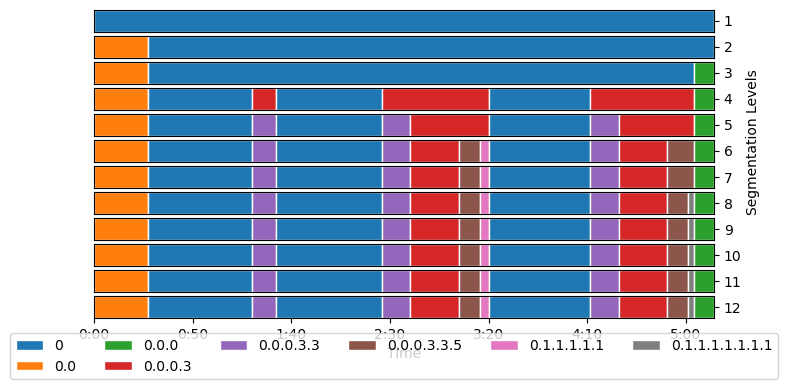

In [71]:
h = get_adobe_hiers(tid).force_mono_L(min_seg_dur=2)
h.plot()

(<Figure size 800x400 with 7 Axes>,
 array([<Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
        <Axes: xlabel='Time'>], dtype=object))

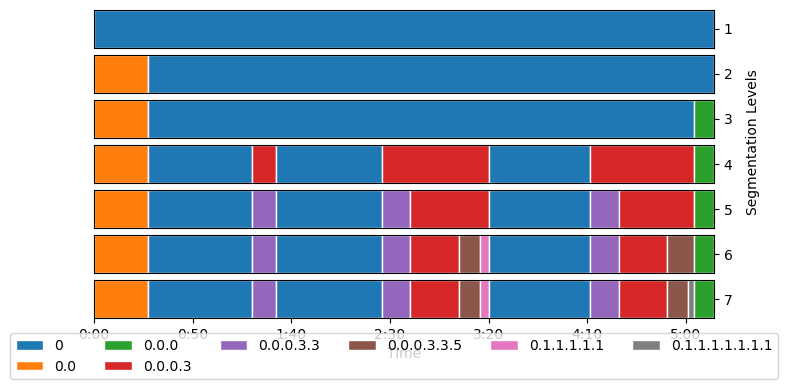

In [73]:
h.prune_identical_levels().plot()

In [ ]:
mir_eval.hierarchy.tmeasure()

(<Figure size 800x400 with 12 Axes>,
 array([<Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
        <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
        <Axes: xlabel='Time'>], dtype=object))

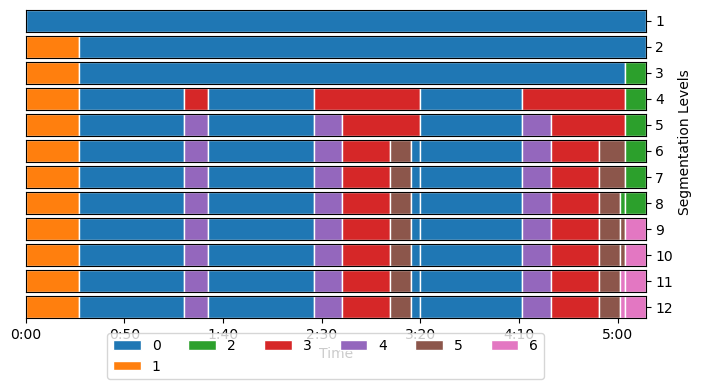

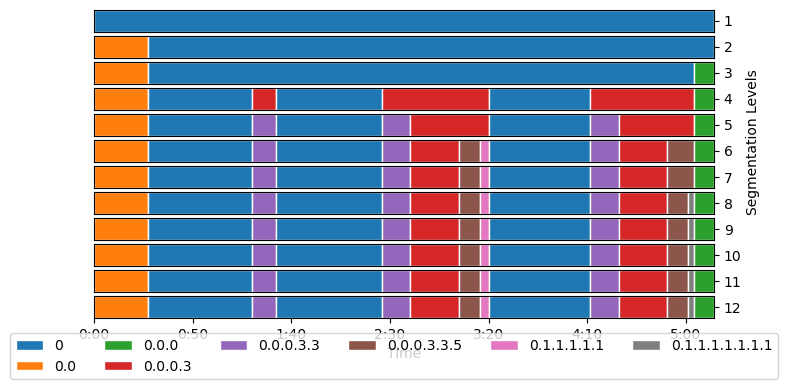

In [56]:
get_adobe_hiers(tid).force_mono_B(min_seg_dur=2).plot(relabel=False)
get_adobe_hiers(tid).force_mono_L(min_seg_dur=2).plot(relabel=True)

In [ ]:
# Let's do it on all files
from tqdm import tqdm

for tid in tqdm(get_salami_tids()):
    hiers = get_ref_hiers(tid)
    for anno_id, h in enumerate(hiers):
        if not h.has_mono_B():
            print(f'{tid} annotator {anno_id} has non-monotonic boundaries!')

## Everything has monotonic boundaries!

100%|██████████| 1359/1359 [00:13<00:00, 101.53it/s]


(<Figure size 800x500 with 2 Axes>,
 array([<Axes: >, <Axes: xlabel='Time'>], dtype=object))

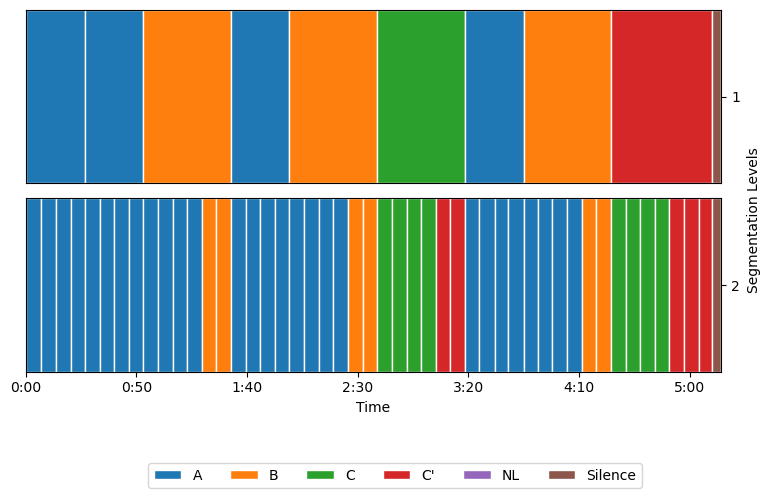

In [19]:
hiers[1].plot()